# Ejercicio de Regresión Lineal

Cynthia CRistal Quijas Flores

En este notebook intentaremos predecir cuántas veces será compartido en Redes Sociales un artículo de Machine Learning segun algunas de sus características

## Predicción: ¿Cuántas veces será compartido un artículo del Blog?

Vamos a comenzar por Importar y Visualizar los datos

In [4]:
# Imports necesarios
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
#cargamos los datos de entrada
data = pd.read_csv("articulos_ml.csv")

In [6]:
#veamos cuantas dimensiones y registros contiene
data.shape

(161, 8)

In [7]:
#son 161 registros con 8 columnas. Veamos los primeros registros para tener una idea
data.head()

,Title,url,Word count,# of Links,# of comments,# Images video,Elapsed days,# Shares
0,What is Machine Learning and how do we use it ...,https://blog.signals.network/what-is-machine-l...,1888,1,2.0,2,34,200000
1,10 Companies Using Machine Learning in Cool Ways,NaN,1742,9,NaN,9,5,25000
2,How Artificial Intelligence Is Revolutionizing...,NaN,962,6,0.0,1,10,42000
3,Dbrain and the Blockchain of Artificial Intell...,NaN,1221,3,NaN,2,68,200000
4,Nasa finds entire solar system filled with eig...,NaN,2039,1,104.0,4,131,200000


Vemos que algunos campos (por ejemplo en comentarios) tienen valores nulos.

En nuestro caso la columna Shares será nuestra salida, es decir nuestro valor "Y", el valor que queremos predecir

In [8]:
# Ahora veamos algunas estadísticas de nuestros datos
data.describe()

,Word count,# of Links,# of comments,# Images video,Elapsed days,# Shares
count,161.000000,161.000000,129.000000,161.000000,161.000000,161.000000
mean,1808.260870,9.739130,8.782946,3.670807,98.124224,27948.347826
std,1141.919385,47.271625,13.142822,3.418290,114.337535,43408.006839
min,250.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,990.000000,3.000000,2.000000,1.000000,31.000000,2800.000000
50%,1674.000000,5.000000,6.000000,3.000000,62.000000,16458.000000
75%,2369.000000,7.000000,12.000000,5.000000,124.000000,35691.000000
max,8401.000000,600.000000,104.000000,22.000000,1002.000000,350000.000000


De aqui observamos que por ejemplo la media de Cantidad de palabras es 1808

Hay un artíclo mínimo con 250 palabras y el máximo contiene 8401.

Y en cuanto a las salidas, vemos mínimo de 0 veces compartido y máximo de 350000 (eso es mucho!)

## Visualización General

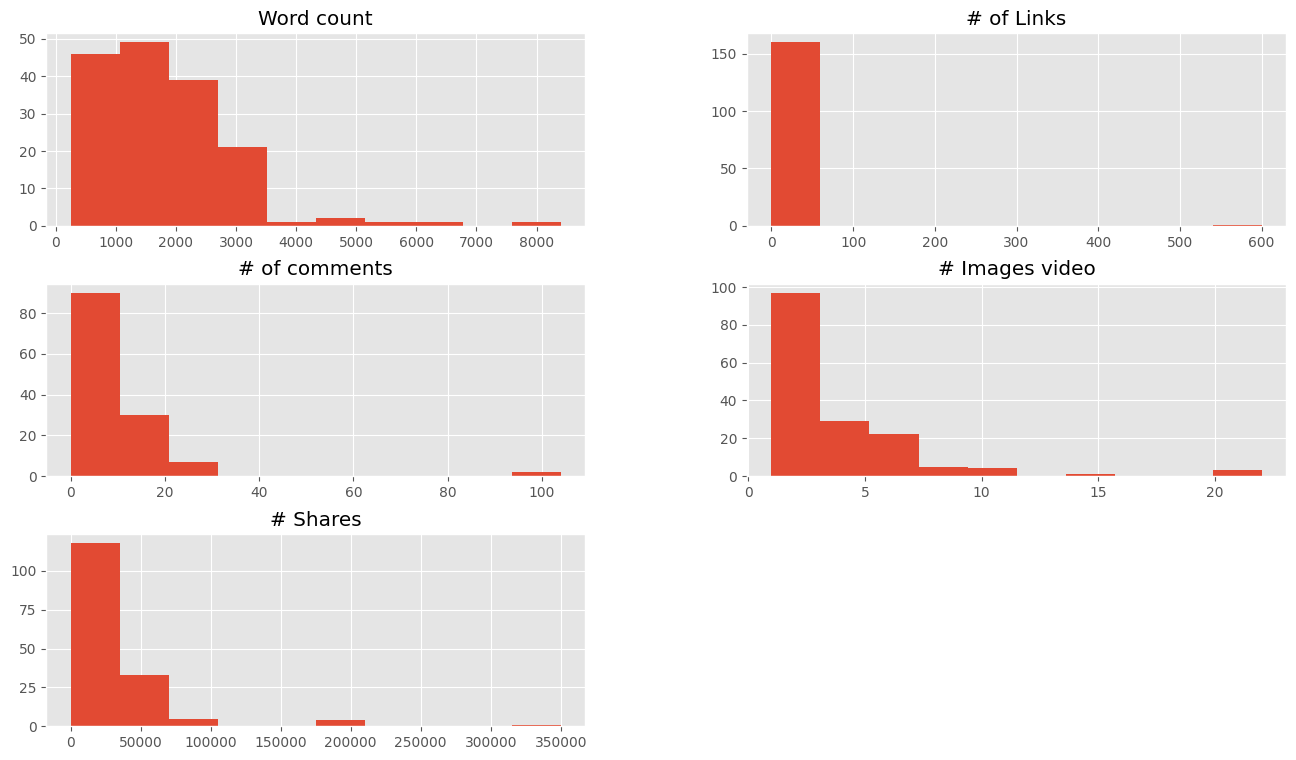

In [30]:
# Visualizamos rápidamente las caraterísticas de entrada
data.drop(['Title','url', 'Elapsed days'],axis=1).hist()
plt.show()

## Visualizamos Cantidad de Palabras vs. Compartidos

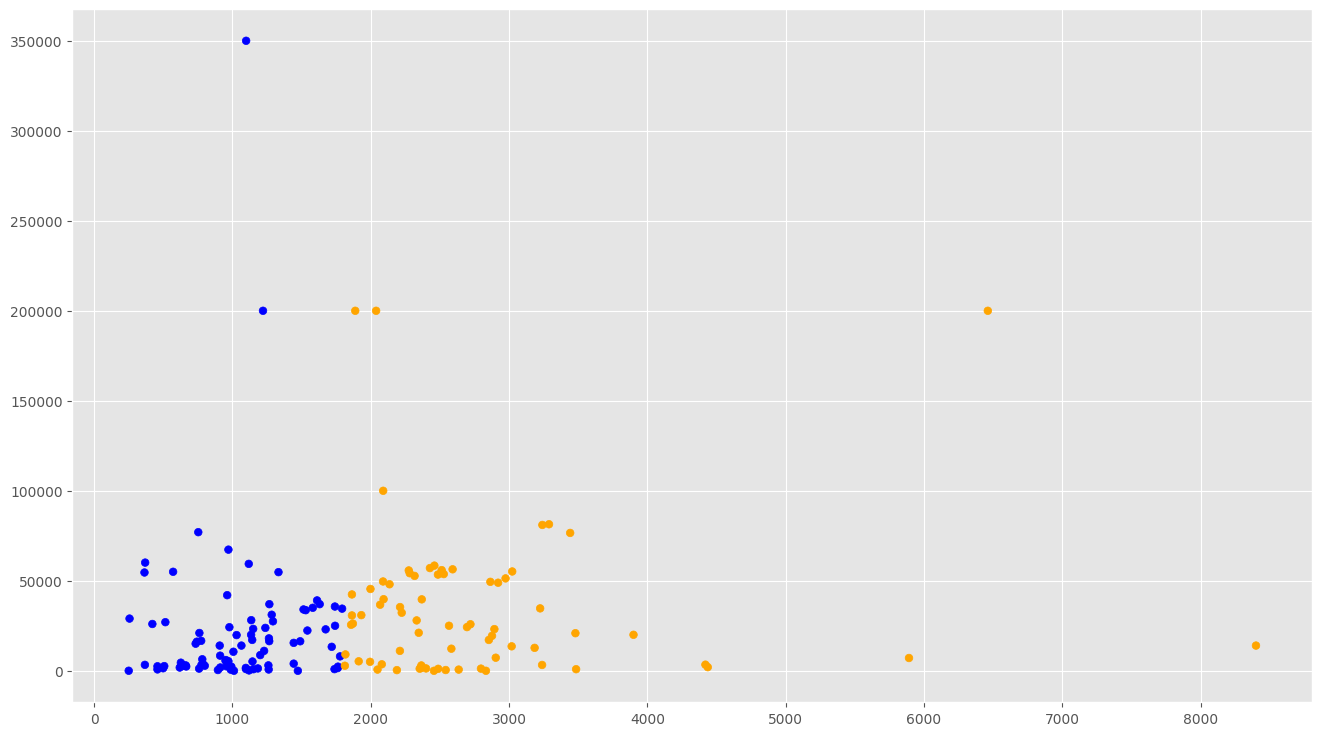

In [10]:
#vamos a Visualizar los datos de entrada
colores=['orange','blue']
tamanios=[30,60]

f1 = data['Word count'].values
f2 = data['# Shares'].values

# Vamos a pintar en 2 colores los puntos por debajo de la media de Cantidad de Palabras
asignar=[]
for index, row in data.iterrows():
    if(row['Word count']>1808):
        asignar.append(colores[0])
    else:
        asignar.append(colores[1])
    
plt.scatter(f1, f2, c=asignar, s=tamanios[0])
plt.show()

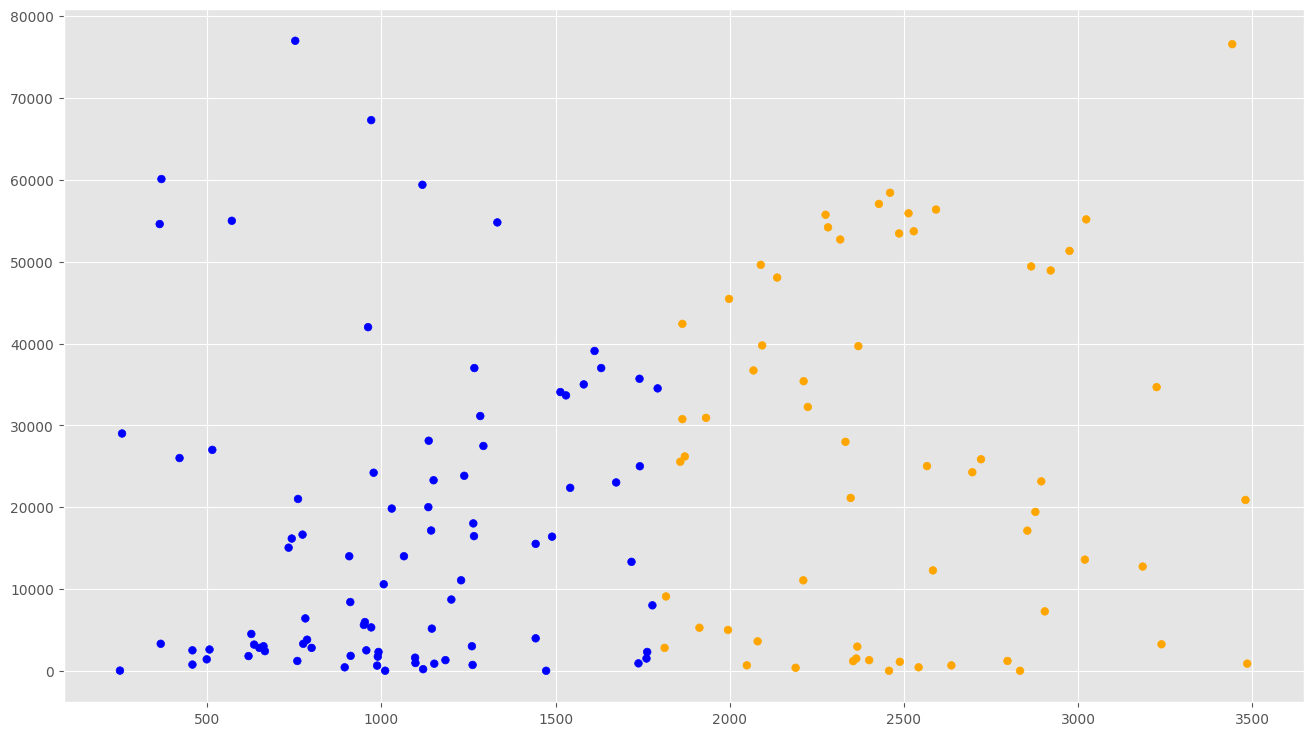

In [11]:
# Vamos a RECORTAR los datos en la zona donde se concentran más los puntos
# esto es en el eje X: entre 0 y 3.500
# y en el eje Y: entre 0 y 80.000
filtered_data = data[(data['Word count'] <= 3500) & (data['# Shares'] <= 80000)]

f1 = filtered_data['Word count'].values
f2 = filtered_data['# Shares'].values

# Vamos a pintar en colores los puntos por debajo y por encima de la media de Cantidad de Palabras
asignar=[]
for index, row in filtered_data.iterrows():
    if(row['Word count']>1808):
        asignar.append(colores[0])
    else:
        asignar.append(colores[1])
    
plt.scatter(f1, f2, c=asignar, s=tamanios[0])
plt.show()

In [12]:
# Veamos como cambian los valores una vez filtrados
filtered_data.describe()

,Word count,# of Links,# of comments,# Images video,Elapsed days,# Shares
count,148.000000,148.000000,121.000000,148.000000,148.000000,148.000000
mean,1640.209459,5.743243,7.256198,3.331081,91.554054,20545.648649
std,821.975365,6.064418,6.346297,2.706476,91.143923,19933.865031
min,250.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,971.000000,3.000000,2.000000,1.000000,28.750000,2750.000000
50%,1536.000000,5.000000,6.000000,3.000000,60.000000,15836.000000
75%,2335.750000,7.000000,11.000000,4.000000,110.500000,34177.500000
max,3485.000000,49.000000,30.000000,22.000000,349.000000,77000.000000


## Regresión Lineal Simple (1 variable)

Vamos a intentar primero una Regresión Lineal con 1 sóla variable

In [13]:
# Asignamos nuestra variable de entrada X para entrenamiento y las etiquetas Y.
dataX =filtered_data[["Word count"]]
X_train = np.array(dataX)
y_train = filtered_data['# Shares'].values

In [14]:
# Creamos el objeto de Regresión Linear
regr = linear_model.LinearRegression()

# Entrenamos nuestro modelo
regr.fit(X_train, y_train)

# Hacemos las predicciones que en definitiva una línea (en este caso, al ser 2D)
y_pred = regr.predict(X_train)

# Veamos los coeficienetes obtenidos, En nuestro caso, serán la Tangente
print('Coefficients: \n', regr.coef_)
# Este es el valor donde corta el eje Y (en X=0)
print('Independent term: \n', regr.intercept_)
# Error Cuadrado Medio
print("Mean squared error: %.2f" % mean_squared_error(y_train, y_pred))
# Puntaje de Varianza. El mejor puntaje es un 1.0
print('Variance score: %.2f' % r2_score(y_train, y_pred))

Coefficients: 
 [5.69765366]
Independent term: 
 11200.30322307416
Mean squared error: 372888728.34
Variance score: 0.06


## Visualizamos la Recta que obtuvimos

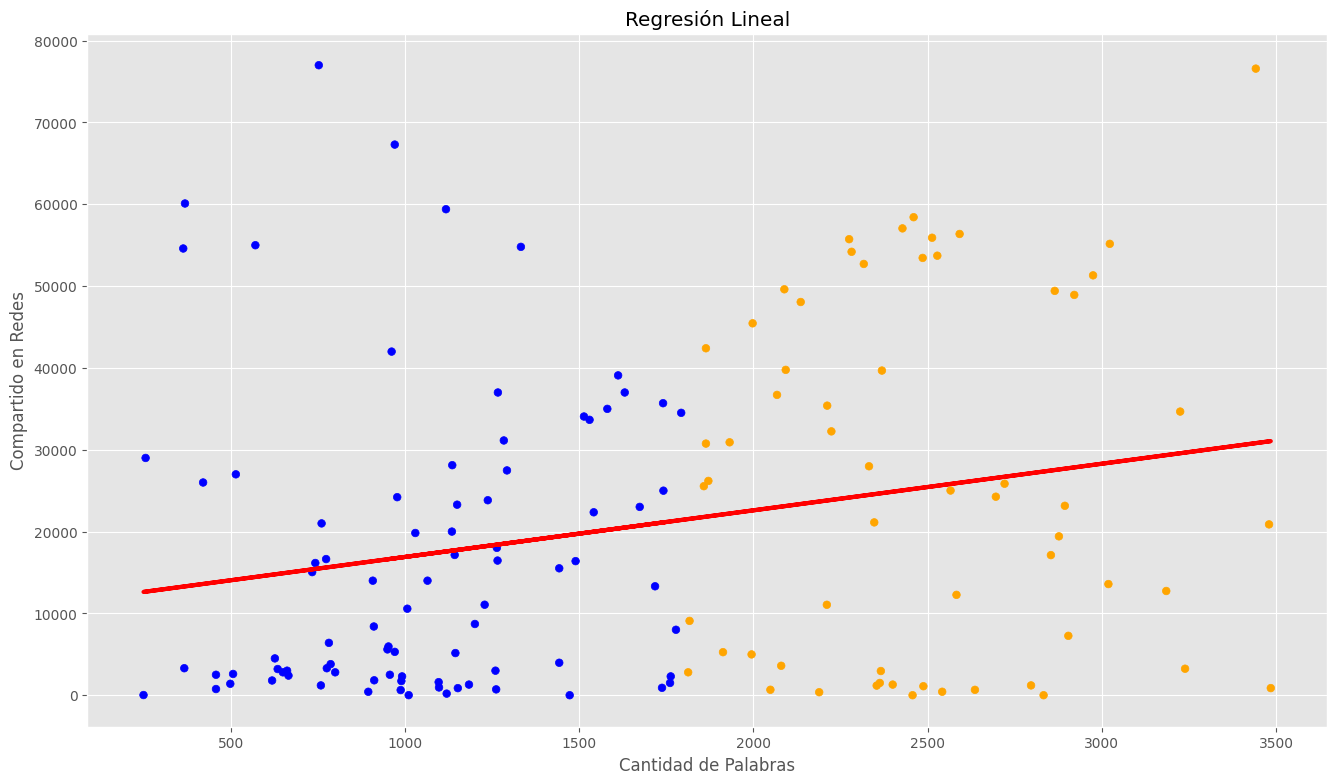

In [15]:
plt.scatter(X_train[:,0], y_train,  c=asignar, s=tamanios[0])
plt.plot(X_train[:,0], y_pred, color='red', linewidth=3)

plt.xlabel('Cantidad de Palabras')
plt.ylabel('Compartido en Redes')
plt.title('Regresión Lineal')

plt.show()

### Predicción 1

In [16]:
#Vamos a comprobar:
# Quiero predecir cuántos "Shares" voy a obtener por un artículo con 2.000 palabras,
# según nuestro modelo, hacemos:
y_Dosmil = regr.predict([[2000]])
print(int(y_Dosmil))

22595


Evidentemente No es tan sencillo...

Vamos a mejorar un poco el modelo

# Regresión Lineal Múltiples (múltiples variables)

In [17]:
#Vamos a intentar mejorar el Modelo, con una dimensión más: 
# Para poder graficar en 3D, haremos una variable nueva que será la suma de los enlaces, comentarios e imágenes
suma = (filtered_data["# of Links"] + filtered_data['# of comments'].fillna(0) + filtered_data['# Images video'])

dataX2 =  pd.DataFrame()
dataX2["Word count"] = filtered_data["Word count"]
dataX2["suma"] = suma
XY_train = np.array(dataX2)
z_train = filtered_data['# Shares'].values

Atención: Esta vez, nuestras dimensiones de entrenamiento serán X e Y y las etiquetas de predicción serán z.

In [18]:
# Creamos un nuevo objeto de Regresión Lineal
regr2 = linear_model.LinearRegression()

# Entrenamos el modelo, esta vez, con 2 dimensiones
# obtendremos 2 coeficientes, para graficar un plano
regr2.fit(XY_train, z_train)

# Hacemos la predicción con la que tendremos puntos sobre el plano hallado
z_pred = regr2.predict(XY_train)

# Los coeficientes
print('Coefficients: \n', regr2.coef_)
# Error cuadrático medio
print("Mean squared error: %.2f" % mean_squared_error(z_train, z_pred))
# Evaluamos el puntaje de varianza (siendo 1.0 el mejor posible)
print('Variance score: %.2f' % r2_score(z_train, z_pred))

Coefficients: 
 [   6.63216324 -483.40753769]
Mean squared error: 352122816.48
Variance score: 0.11


## Esta vez visualizamos un plano

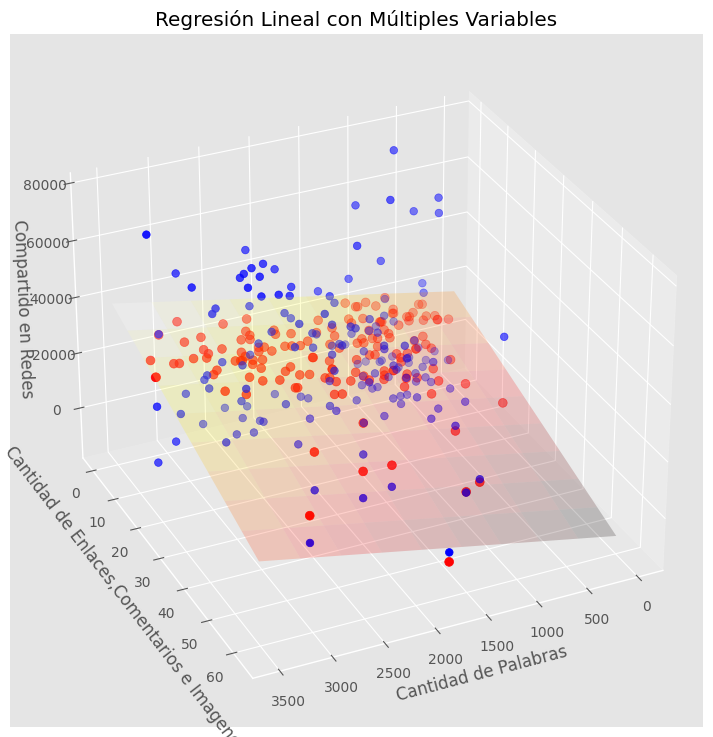

In [28]:
fig = plt.figure()
ax = plt.axes(projection='3d')

# Creamos una malla, sobre la cual graficaremos el plano
xx, yy = np.meshgrid(np.linspace(0, 3500, num=10), np.linspace(0, 60, num=10))

# calculamos los valores del plano para los puntos x e y
nuevoX = (regr2.coef_[0] * xx)
nuevoY = (regr2.coef_[1] * yy) 

# calculamos los correspondientes valores para z. Debemos sumar el punto de intercepción
z = (nuevoX + nuevoY + regr2.intercept_)

# Graficamos el plano
ax.plot_surface(xx, yy, z, alpha=0.2, cmap='hot')

# Graficamos en azul los puntos en 3D
ax.scatter(XY_train[:, 0], XY_train[:, 1], z_train, c='blue',s=30)

# Graficamos en rojo, los puntos que 
ax.scatter(XY_train[:, 0], XY_train[:, 1], z_pred, c='red',s=40)

# con esto situamos la "camara" con la que visualizamos
ax.view_init(elev=30., azim=65)
        
ax.set_xlabel('Cantidad de Palabras')
ax.set_ylabel('Cantidad de Enlaces,Comentarios e Imagenes')
ax.set_zlabel('Compartido en Redes')
ax.set_title('Regresión Lineal con Múltiples Variables')
plt.show()

### Predicción 2

In [20]:
# Si quiero predecir cuántos "Shares" voy a obtener por un artículo con: 
# 2000 palabras y con enlaces: 10, comentarios: 4, imagenes: 6
# según nuestro modelo, hacemos:

z_Dosmil = regr2.predict([[2000, 10+4+6]])
print(int(z_Dosmil))

20518


## Comparemos las predicciónes obtenidas en los modelos

En este caso, Obtuvimos mejora en el modelo de 2 dimensiones

In [21]:
# Restamos los errores calculados antes:
# Obviamente, "menos error" es mejor
mejoraEnError = mean_squared_error(y_train, y_pred) - mean_squared_error(z_train, z_pred)
print(mejoraEnError)

20765911.860715985


In [22]:
# También calculamos la mejora en la varianza:
mejoraEnVarianza = r2_score(z_train, z_pred) - r2_score(y_train, y_pred)
print(mejoraEnVarianza)
# Aunque no parezca mucho, recordemos que el valor más alto que se puede obtener es 1.0

0.052615337462582956


In [23]:
# Finalmente, mejoramos en nuestra predicción de un artículo de 2.000 palabras, 
# pues aunque disminuyen los "Shares" que obtendremos en el 2do modelo, 
# seguramente será un valor más cercano a la realidad
diferenciaComparir = z_Dosmil - y_Dosmil
print(int(diferenciaComparir))

-2077


# Mejorar las predicciones y notas finales

En este ejemplo utilizamos información de artículos sobre Machine Learning con algunos datos ficticios 
en nuestro .csv pero si quisieramos tratar de mejorar
las predicciones, deberiamos utilizar más de 2 variables (recordemos que aqui lo hicimos para poder
graficar en 3D).
Sería conveniente además conseguir mejores características de entrada, pues no es lo mismo un enlace
de un portal con multitud de visitas al mes, que otros Blogs más modestos.